下面是一个简单的教程，我们将使用scutquant的scutquant、alpha、report和executor模块完成一个从用原始数据构建因子，特征工程和数据清洗，划分数据集，使用模型做信号合成，并根据预测值进行模拟实盘回测的全过程 :)

用到的各模块的主要功能如下:  

* scutquant: 主要负责除了因子构建以外的数据处理，包括数据清洗，数据集划分和pca等等，也提供一些可直接调用的简单的模型（主要是树模型和线性模型）
* alpha: 主要负责与因子相关的数据处理，并批量生成因子（对单因子的精细处理可通过底层的operators模块实现），提供单因子回测函数
* report: 主要负责对计算结果生成报告，无论是因子数据（single_factor_ana）还是分组报告（group_return_ana）还是整个回测的报告
* executor: 根据预测值和策略按datetime（可以是任何频率的数据）执行回测，并返回一个executor对象，其中包含了用户的账户对象user_account，内含回测的全部细节

In [1]:
# 导入需要用到的库
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

样例数据集只有基础的价量数据，以面板数据的形式呈现. 当需要额外数据构建因子时(例如需要构建市场因子Rm), 就需要读取supplemental data. 当补充数据为时序数据时，可以使用join_data函数将其合并到数据集中；当补充数据为各个股票的截面数据时，可以使用join_data_by_code按股票代码将数据合并到数据集中

In [2]:
# 读取数据
df = pd.read_csv("D:/Desktop/csidata.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index(["datetime", "instrument"], inplace=True)
df

open   high    low  close  pre_close  change  pct_chg  \
datetime   instrument                                                           
2006-01-04 000001.SZ    6.13   6.33   6.12   6.28       6.14    0.14   2.2800   
           000002.SZ    4.40   4.67   4.40   4.66       4.31    0.35   8.1200   
           000012.SZ    4.70   4.75   4.55   4.70       4.62    0.08   1.7300   
           000016.SZ    3.52   3.58   3.52   3.57       3.52    0.05   1.4200   
           000021.SZ    7.99   8.40   7.99   8.32       8.00    0.32   4.0000   
...                      ...    ...    ...    ...        ...     ...      ...   
2023-07-27 688363.SH   94.34  96.20  94.00  95.90      94.70    1.20   1.2672   
           688396.SH   55.25  56.25  54.92  55.36      54.92    0.44   0.8012   
           688561.SH   48.96  49.38  48.80  48.83      49.11   -0.28  -0.5701   
           688599.SH   36.40  37.29  36.36  36.39      36.61   -0.22  -0.6009   
           688981.SH   50.01  50.14  49.20  49.39      50.15   -0.76  -1.5155   

                             amount     volume  
datetime   instrument                           
2006-01-04 000001.SZ    96989.00660  154450.68  
           000002.SZ   175187.06570  389310.43  
           000012.SZ    18863.86250   40399.61  
           000016.SZ     5131.87930   14426.65  
           000021.SZ    27657.17080   33526.60  
...                             ...        ...  
2023-07-27 688363.SH   276386.76000   28957.40  
           688396.SH   218456.02400   39268.57  
           688561.SH    76213.86113   15532.40  
           688599.SH   456467.83070  124308.87  
           688981.SH   812613.12370  163390.62  

[1240545 rows x 9 columns]

**关于目标值:** 为了避免数据泄露和其它各种问题，我们构建的目标值应尽量与已知数据无关(即$y_t$无法用已知的数据${X_t, X_{t-1}, ...}$计算得到). 这里我们选择$label = \frac{close_{-2}}{close_{-1}} - 1$, 即T时刻需要预测的目标值是T+2相对于T+1的收益率, 现实意义是在今天(T)作出预测, 并在明天(T+1)以收盘价开仓, 后天(T+2)以收盘价平仓  

**关于因子:** 参考alpha模块中的make_factors()和alpha360(), 前者主要为技术指标, 后者是原始量价数据的滞后项除单位, 目的是让模型在张成的360维空间中自行发掘因子

In [3]:
# 构造目标值
df["label"] = df["pct_chg"].groupby("instrument").shift(-2) / 100
df = df.dropna() 

In [4]:
X = alpha.qlib158(df)
X = pd.concat([X, df[["label"]]], axis=1)
X

open1     open2     open3     open4     open5  \
datetime   instrument                                                     
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN       NaN   
           000002.SZ        NaN       NaN       NaN       NaN       NaN   
           000012.SZ        NaN       NaN       NaN       NaN       NaN   
           000016.SZ        NaN       NaN       NaN       NaN       NaN   
           000021.SZ        NaN       NaN       NaN       NaN       NaN   
...                         ...       ...       ...       ...       ...   
2023-07-25 688363.SH   0.998085  0.962660  0.961277  0.953936  0.947979   
           688396.SH   0.986727  0.979818  0.985455  0.981818  0.985273   
           688561.SH   0.973039  0.970809  0.991689  1.003446  1.012568   
           688599.SH   0.986260  0.989283  1.002748  1.006046  1.016488   
           688981.SH   0.982118  0.984730  0.991159  0.994575  0.984529   

                         close1    close2    close3    close4    close5  ...  \
datetime   instrument                                                    ...   
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000002.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000012.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000016.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000021.SZ        NaN       NaN       NaN       NaN       NaN  ...   
...                         ...       ...       ...       ...       ...  ...   
2023-07-25 688363.SH   0.992553  0.998085  0.959362  0.953617  0.958191  ...   
           688396.SH   0.992727  0.987091  0.977091  0.978909  0.989273  ...   
           688561.SH   0.985404  0.974458  0.976485  0.992905  0.994121  ...   
           688599.SH   0.971146  0.983787  0.990932  0.994504  1.009893  ...   
           688981.SH   0.984529  0.984529  0.990356  0.987543  0.998594  ...   

                        vsump10   vsump20   vsump30   vsump60    vsumn5  \
datetime   instrument                                                     
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN       NaN   
           000002.SZ        NaN       NaN       NaN       NaN       NaN   
           000012.SZ        NaN       NaN       NaN       NaN       NaN   
           000016.SZ        NaN       NaN       NaN       NaN       NaN   
           000021.SZ        NaN       NaN       NaN       NaN       NaN   
...                         ...       ...       ...       ...       ...   
2023-07-25 688363.SH   0.151169  0.067856 -0.234478 -0.047606 -0.242995   
           688396.SH   0.014767 -0.099715 -0.278204 -0.085300 -0.033904   
           688561.SH  -0.097845 -0.065561 -0.088517 -0.032193  0.307803   
           688599.SH   0.060621 -0.044404 -0.141937 -0.018149 -0.046496   
           688981.SH  -0.022692 -0.010020 -0.058739 -0.073201  0.429199   

                        vsumn10   vsumn20   vsumn30   vsumn60     label  
datetime   instrument                                                    
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN  0.014200  
           000002.SZ        NaN       NaN       NaN       NaN -0.006400  
           000012.SZ        NaN       NaN       NaN       NaN  0.000000  
           000016.SZ        NaN       NaN       NaN       NaN  0.002700  
           000021.SZ        NaN       NaN       NaN       NaN -0.003600  
...                         ...       ...       ...       ...       ...  
2023-07-25 688363.SH  -0.151169 -0.067856  0.234478  0.047606  0.012672  
           688396.SH  -0.014767  0.099715  0.278204  0.085300  0.008012  
           688561.SH   0.097845  0.065561  0.088517  0.032193 -0.005701  
           688599.SH  -0.060621  0.044404  0.141937  0.018149 -0.006009  
           688981.SH   0.022692  0.010020  0.058739  0.073201 -0.015155  

[1238773 rows x 150 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1238773 entries, (Timestamp('2006-01-04 00:00:00'), '000001.SZ') to (Timestamp('2023-07-25 00:00:00'), '688981.SH')
Columns: 150 entries, open1 to label
dtypes: float64(150)
memory usage: 1.4+ GB
None
X_mis= 1.3728966754468603
original data:


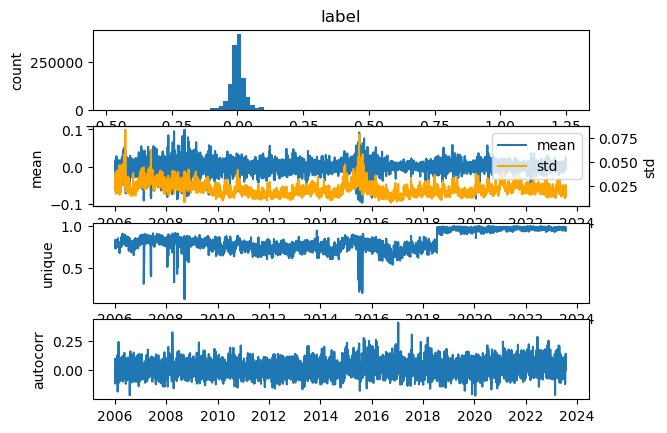

data processed:


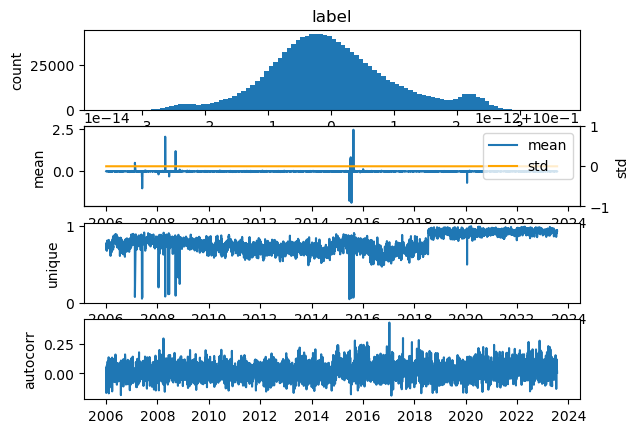

process dataset done
split data done 

all works done 



In [5]:
split_params = {
    "test_start_date": "2017-01-01",
    "split_method": "split_by_date",
    "split_kwargs":{
        "train_end_date": "2014-12-31",
        "valid_end_date": "2016-12-31"
    }
}
# 使用auto_process按照标准流程进行数据处理, 并按split_params拆分出训练集、验证集和测试集
result = q.auto_process(X, "label", split_params=split_params)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"]
X_test = result["X_test"]

Training until validation scores don't improve for 50 rounds
[20]	train's l2: 0.990334	valid's l2: 0.993367
[40]	train's l2: 0.986762	valid's l2: 0.992122
[60]	train's l2: 0.984186	valid's l2: 0.991458
[80]	train's l2: 0.982103	valid's l2: 0.991023
[100]	train's l2: 0.980218	valid's l2: 0.990785
[120]	train's l2: 0.978448	valid's l2: 0.990498
[140]	train's l2: 0.976687	valid's l2: 0.990372
[160]	train's l2: 0.975069	valid's l2: 0.990206
[180]	train's l2: 0.973482	valid's l2: 0.990112
[200]	train's l2: 0.971991	valid's l2: 0.990024
[220]	train's l2: 0.970673	valid's l2: 0.990038
[240]	train's l2: 0.969357	valid's l2: 0.990059
[260]	train's l2: 0.967999	valid's l2: 0.990021
[280]	train's l2: 0.966692	valid's l2: 0.98995
[300]	train's l2: 0.96545	valid's l2: 0.989909
[320]	train's l2: 0.964202	valid's l2: 0.989894
[340]	train's l2: 0.962982	valid's l2: 0.989929
[360]	train's l2: 0.961725	valid's l2: 0.989994
Early stopping, best iteration is:
[325]	train's l2: 0.963943	valid's l2: 0.98987

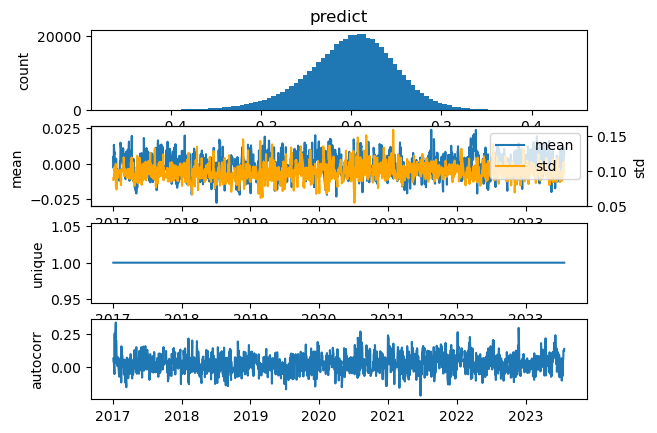

In [6]:
# 拟合模型
model = q.auto_lgbm(X_train, y_train, X_valid, y_valid, early_stopping=50)

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
report.single_factor_ana(pred.iloc[:, 0])

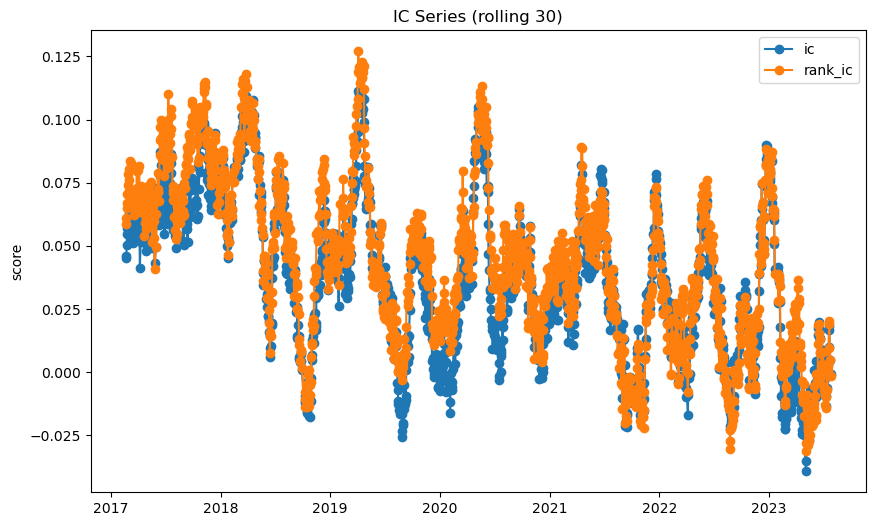

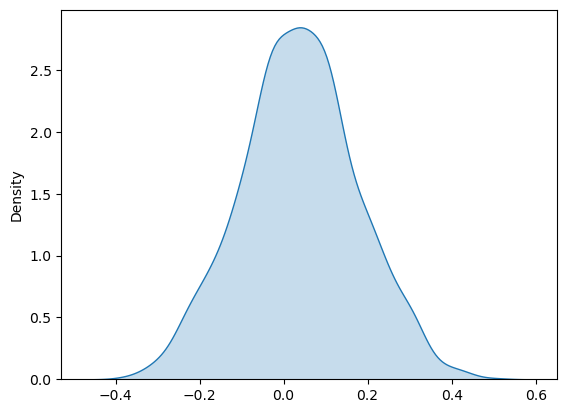

ic= 0.036679357602671776 icir= 0.26496416365933356 rank_ic= 0.043210968647867914 rank_icir= 0.3073891944081541


0.028552477624994407

In [7]:
df_test = df[df.index.isin(pred.index)]
target = df_test["label"]  # 真实收益率
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, target, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"], target)
r

In [8]:
# 以下为回测部分
# 将预测值处理成回测需要的格式(需要知道预测值"predict", 交易价格price和交易量volume)
pred = executor.prepare(pred, df_test, price='close', volume='volume', real_ret=target)

Accuracy of Prediction: 0.5305078436586015


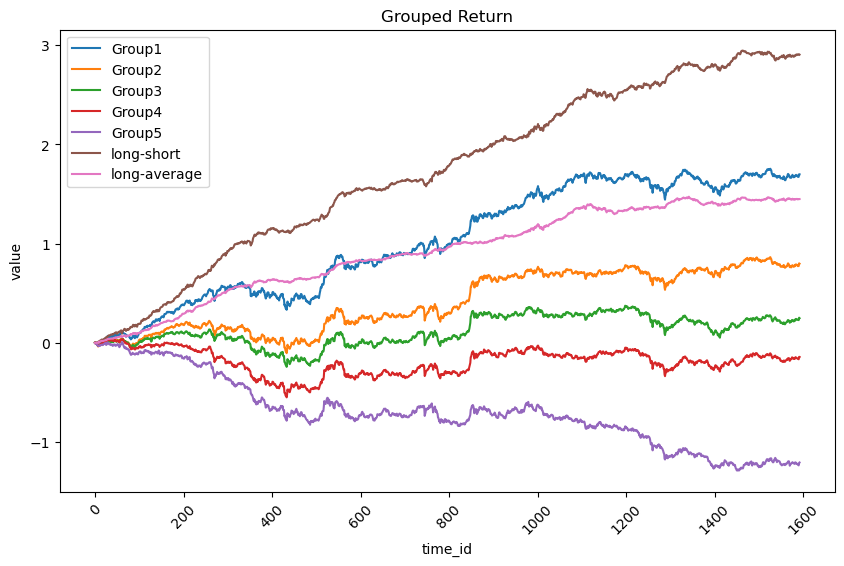

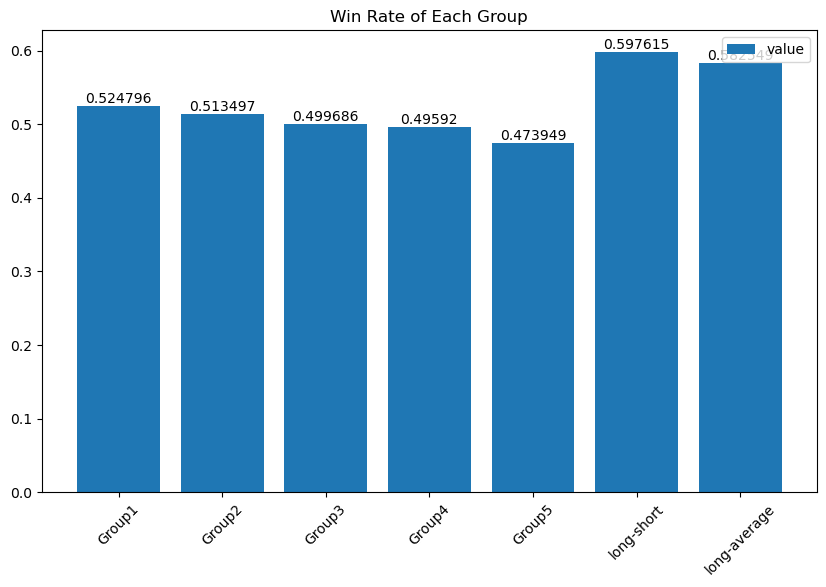

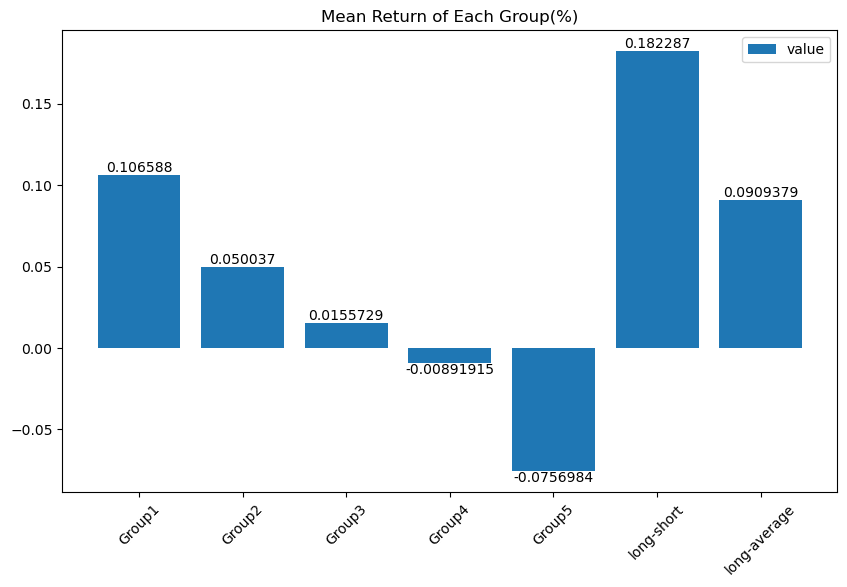

In [9]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, target)

In [10]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前k*100%股票, 做空后k*100%的股票. 自动平仓
        "kwargs": {
            "k": 0.2,
            "auto_offset": True,
            "offset_freq": 6, # 应为freq + 1, 例如一周自动平仓一次, 那就是5+1=6
            "long_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 0, # 融券做空的数量, 默认用底仓做空(short_volume=0)
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.05  # 手数随可用资金而改变，最大不会超过股票当天成交量的1%(例如T+1时下单，下单手数不会超过T时成交量的1%)
        }
    },
    "account": None, # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

Annualized Return: 0.04766121874545859
Annualized Volatility: 0.06845809449052727
Annualized Return(Benchmark): 0.021590437165114107
Annualized Volatility(Benchmark): 0.05436810102330756 

Cumulative Rate of Return: 0.3422232961296423
Cumulative Rate of Return(Benchmark): 0.1445710274990879
Cumulative Excess Rate of Return: 0.1976522686305544 

Max Drawdown: -0.17387661468012752
Max Drawdown(Benchmark): -0.3468412286672688
Max Drawdown(Excess Return): -0.13507930276278257 

Sharpe Ratio: 1.570074601436393
Sortino Ratio: 6.148751775900926
Information Ratio: 2.194986040962336 

Beta: 1.0725615236499946
Alpha: 0.1939396497948621
Epsilon: 0.09016607425662562
Profitable Days(%): 0.9811676082862524


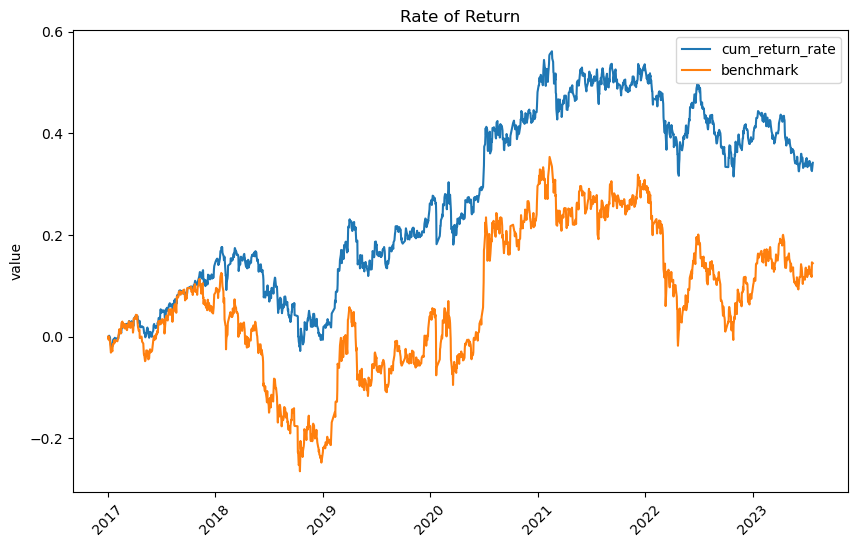

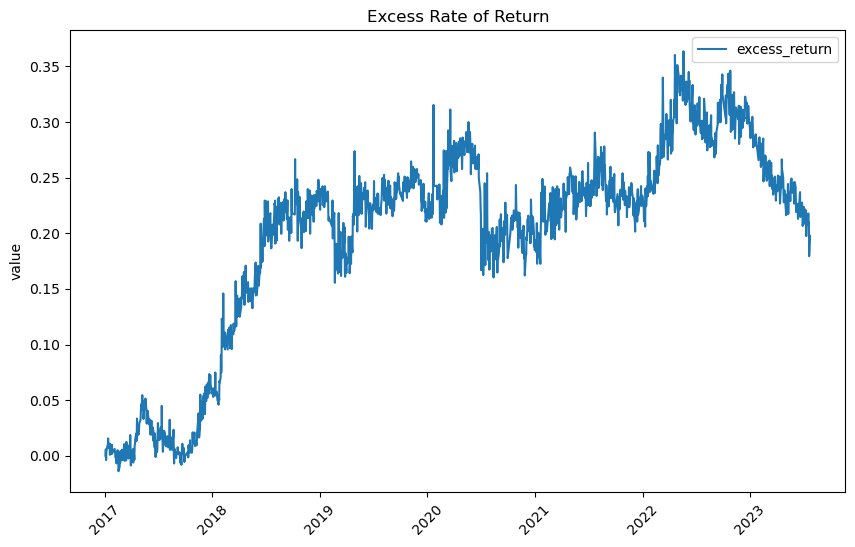

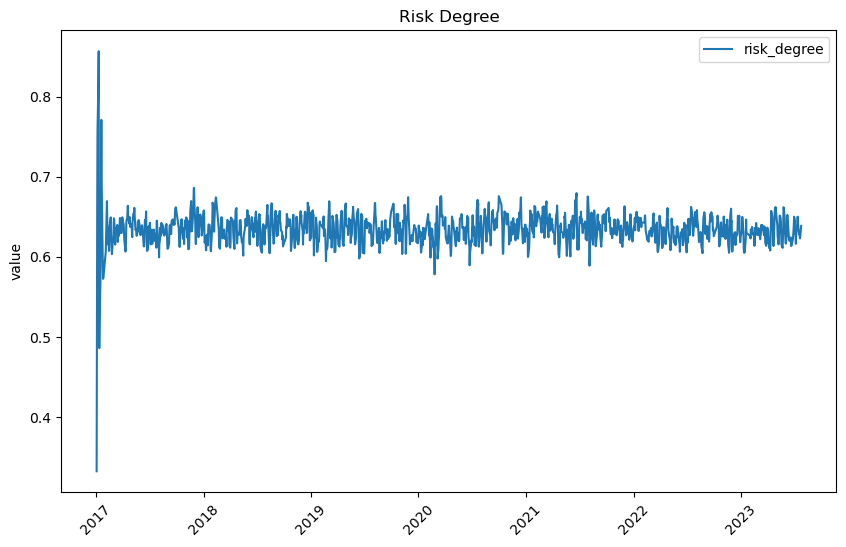

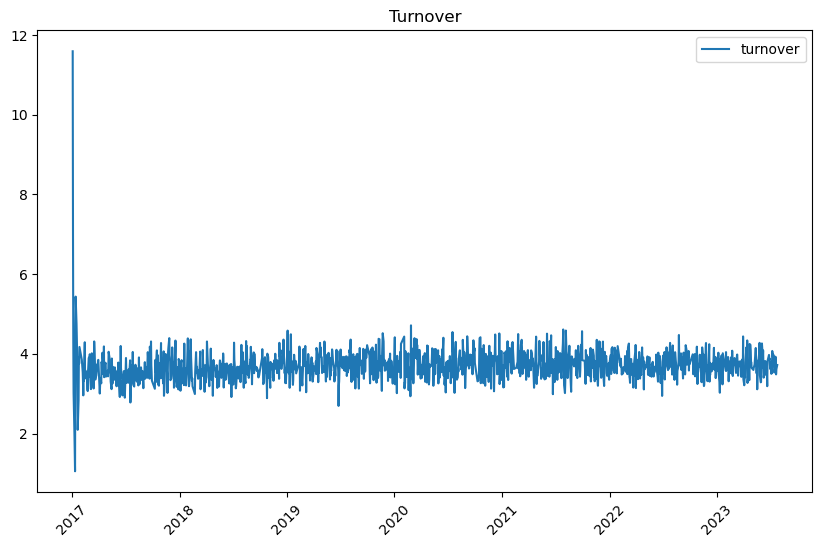

In [11]:
# 报告回测结果
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=1, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [12]:
# user_account.buy_hist

In [13]:
# user_account.position